In [3]:
!pip install shapely

  Using cached shapely-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached shapely-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)


In [4]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv

In [5]:
DATASET_PATH = Path() / 'midv500/midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

packs = MidvPackage.read_midv500_dataset(DATASET_PATH)

### Алгоритм будет состоять из нескольких чатей:
1. Выделение ключевых точек и matching между template'ом и картинокой
3. Из полученной информации строит матрицу перехода и углы квадрата нужного по ней

#### Использованные материалы (в т.ч. код):
- https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
- https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
- https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
- https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html
- https://learnopencv.com/contour-detection-using-opencv-python-c/
- https://docs.opencv.org/4.x/df/dd2/tutorial_py_surf_intro.html


In [6]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)

In [7]:
def convert_to_gray_np(img):
    return cv.cvtColor(np.array(img), cv.COLOR_BGR2GRAY)

class KPMatcher:
    '''
        Хранит шаблонное фото, а также последнюю обработанную
        Также умеет рисовать соответствие ключевых точек
    '''
    def __init__(self, matcher):
        '''
            Принимает объект класса matcher
            Должен быть метод detect(img)
            Также должен быть метод compute(img, kp)
        '''
        self.matcher = matcher
        self.sift = cv.SIFT_create()
        self.template_init = False
   
    def init_template(self, template_img):
        '''
            Нужно проинициализировать шаблонное фото
        '''
        self.template_img = template_img
        template_img = convert_to_gray_np(template_img)
        self.template_kp, self.template_des = self.sift.detectAndCompute(template_img, None)
        self.template_init = True

    def get_matches(self, img):
        '''
            Принимает img и инициализирует last параметры
        '''
        if not self.template_init:
            print('template has not been initialized')
            return
        self.last_img = img
        img = convert_to_gray_np(img)
        kp, des = self.sift.detectAndCompute(img, None)
        
        self.last_kp, self.last_des = kp, des
        
        matches = self.matcher.knnMatch(self.template_des, des, k = 2)
        self.matches = self.Lowes_ratio_test(matches, 0.7)
        self.matches = sorted(self.matches, key = lambda x:x.distance)
        
        return matches
    
    def draw_match_with_last(self, match_num = 10):
        matches = sorted(self.matches, key = lambda x:x.distance)
        img3 = cv.drawMatches(
            np.array(self.template_img), self.template_kp,
            np.array(self.last_img), self.last_kp,
            matches[:match_num], None, flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3),plt.show()
    
    
    def Lowes_ratio_test(self, matches, ratio_koef = 0.7):
        good_matches = []
        for templ_match, match in matches:
            if (templ_match.distance < ratio_koef*match.distance):
                good_matches.append(templ_match)
        return good_matches
    
    def draw_masked_match_with_profile(self, mask, profile):
        draw_params = dict(matchColor = (0, 255, 0), # draw matches in green color
                           singlePointColor = None,
                           matchesMask = mask, # draw only inliers
                           flags = 2)
    
        img = np.array(self.last_img)
        img = cv.polylines(img,[np.int32(profile)], True, 
                        (255, 12, 220), 16, cv.LINE_AA)
        
        final_img = cv.drawMatches(
                    np.array(self.template_img), self.template_kp, 
                    img, self.last_kp, self.matches, None, **draw_params)
        
        plt.imshow(final_img, 'gray')
        plt.show() 
    

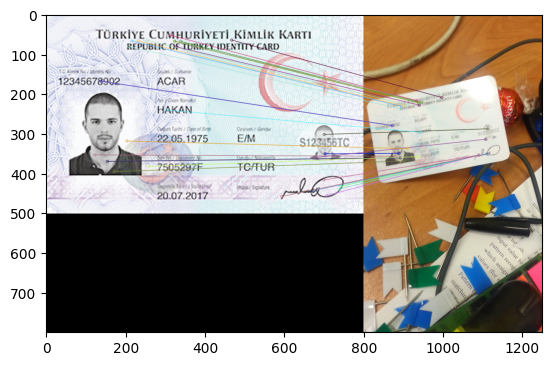

In [8]:
kp_matcher = KPMatcher(flann)

dp = packs[1]
kp_matcher.init_template(dp.template_item.image)
matches = kp_matcher.get_matches(dp[15].image)
kp_matcher.draw_match_with_last(30)

In [9]:
def get_transform_matrix_and_mask(template_kp, kp, matches, template_img, img):
    '''
        По ключевым точкам и изображению сопоставляет углы
    '''
    template_pts = np.float32([template_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    curr_pts = np.float32([ [kp[m.trainIdx].pt] for m in matches]).reshape(-1, 1, 2)
    
    transform_matr, mask = cv.findHomography(template_pts, 
                                          curr_pts, 
                                          cv.RANSAC, 5.0)
    
    mask = mask.ravel().tolist()
    
    return transform_matr, mask

def get_profile(template_img, transform_matr):

    h, w = convert_to_gray_np(template_img).shape
    pts = np.float32([ [0, 0], [0, h-1], [w-1, h-1], [w-1, 0] ]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, transform_matr)
    return dst

transform_matr, mask = get_transform_matrix_and_mask(kp_matcher.template_kp, kp_matcher.last_kp,
                                             kp_matcher.matches,
                                             kp_matcher.template_img, kp_matcher.last_img)

profile = get_profile(kp_matcher.template_img, transform_matr)

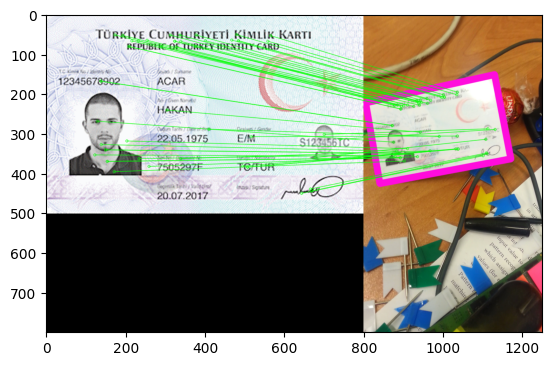

In [10]:
kp_matcher.draw_masked_match_with_profile(mask, profile)

In [11]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 7)
search_params = dict(checks = 100)
flann = cv.FlannBasedMatcher(index_params, search_params)

kp_matcher = KPMatcher(flann)

In [12]:
def cast_to_relative_coordinates(item, cords):
    new_cords = []
    for i in range(len(cords)):
        new_cords.append(cords[i]/item.image_size)
    return np.array(new_cords)

In [13]:
results_dict = dict()

for dp in tqdm(packs):
    kp_matcher.init_template(dp.template_item.image)
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                kp_matcher.get_matches(dp[i].image)
                M, mask = get_transform_matrix_and_mask(
                                             kp_matcher.template_kp, kp_matcher.last_kp,
                                             kp_matcher.matches,
                                             kp_matcher.template_img, kp_matcher.last_img
                )
                profile = get_profile(kp_matcher.template_img, M)
                results_dict[dp[i].unique_key] = cast_to_relative_coordinates(dp[i], profile[:,0])
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)

 74%|███████████████████████████████████████▏             | 37/50 [05:14<04:49, 22.28s/it]

OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'



 94%|█████████████████████████████████████████████████▊   | 47/50 [07:14<00:32, 10.90s/it]

OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.9.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.9.0) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.9.0) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate H

 98%|███████████████████████████████████████████████████▉ | 49/50 [07:45<00:12, 12.46s/it]

OpenCV(4.9.0) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



100%|█████████████████████████████████████████████████████| 50/50 [07:51<00:00,  9.43s/it]


In [14]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy
dump_results_dict(results_dict, Path() / 'pred.json')
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9649
